# Introduction

In this notebook we will make a regression model in order to understand what is more correlated to data scientitsts salaries. We will be using the data from 2020 Stack Overlfow Survey. Since we want to have a better understanding we will be using a linear regression model instead of a more flexible models.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(context='notebook', style='whitegrid', font_scale=1)

# Loading Data

In [2]:
data_folder = 'data'
file_path = os.path.join(data_folder, '2020_data.zip')
df = pd.read_csv(file_path, index_col='Respondent')
df.shape

(64461, 60)

In [3]:
df.dropna(subset=['ConvertedComp', 'DevType'], inplace=True)
ds = df['DevType'].str.contains('Data scientist or machine learning specialist')
ds_df = df[ds].copy()
ds_df.shape

(2619, 60)

# Compensations

In our dataset we have two variables that can be used to measure professionals compensations: `CompTotal` and `ConvertedComp`. Taking a look at some statistics from both variables, it can be seen that `CompTotal` has a much greater standard deviation. This is a result from the different measures of currency in wich `CompTotal` is being measured as well as different periodicity. `ConvertedComp` annualize the `CompTotal` and convert all values to US$. As such it is a better value to used as our regression model dependent variable.

The only transformation that we will be doing is to make the `ConvertedComp` into a monthly compensation.

In [4]:
ds_df[['CompTotal', 'ConvertedComp']].div(12).describe().round(2)

,CompTotal,ConvertedComp
count,2.619000e+03,2619.00
mean,3.181876e+145,10325.93
std,1.628362e+147,23288.35
min,0.000000e+00,0.00
25%,2.208330e+03,2158.50
50%,5.833330e+03,4833.33
75%,1.250000e+04,8733.88
max,8.333333e+148,166666.67


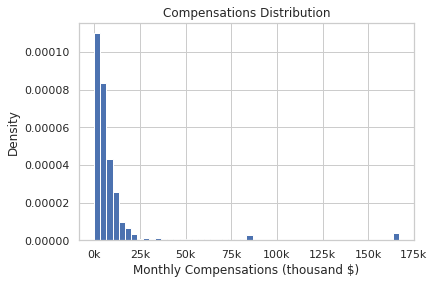

In [5]:
y = ds_df['ConvertedComp'].div(12)
ax = y.hist(bins=50, density=True)
ax.xaxis.set_major_formatter(lambda x, p: f'{x/1000:.0f}k')
plt.xlabel('Monthly Compensations (thousand $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

From the looks of the distribution and also from the distribution quartils values, we can see that `ConvertedComp` distribution is highly skewed. In order to make it less skewed we will be using a log transformation. Another benefit of this transformation is that it will makes it easier to identify patterns and linear correlations. But before making this transformation we need to exclude the `0` values.

In [6]:
(y == 0).sum()

18

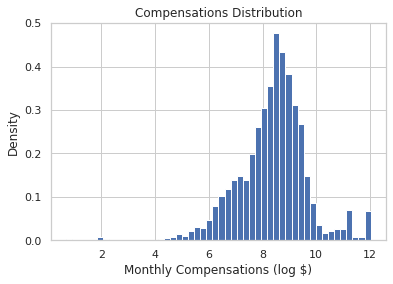

In [7]:
y.drop(y[y == 0].index, inplace=True)
log_y = y.apply(np.log).rename('LogConvertedComp')

log_y.hist(bins=50, density=True)
plt.xlabel('Monthly Compensations (log $)')
plt.ylabel('Density')
plt.title('Compensations Distribution')
plt.show()

# Feature Enginneering

## Categorial Variables

There are a lot of categorical variables in our dataset, in order to prepare them for the model we need to change that to numeric format. For this purpose we will be one hot enconding those categorical variables with pandas `pd.get_dummies` function. Also, there are some questions in each the respondents could answer more than one category. For those questions we need to make some adaptation and separate those answers in order to identify all single options that were used. If we don't do this step and directly apply `pd.get_dummies` we would take as our categories all the combinations of categories that were selecting, greatly increasing the number of features generated by our enconding process.

In [8]:
def dumify_col(col, thereshold=0):
    """Transform a categorical column into multiple dummy variables
    It was made in a way that it can transform into dummies even variables
    that can have multiple categories into a single observation, suposing that
    categories are seperated by ';'.
    """
    
    # separating multiple categories and expanding it into a single series
    exploded_col = col.dropna().str.split(';').explode()
    # computing the dummies and aggregating into the original dimension of
    # the dataframe (minus missing obs)
    dummies_df = (pd.get_dummies(exploded_col, prefix=col.name).
                  reset_index().groupby('Respondent').max())
    
    # optional procedure of removing missing categories (columns)
    # with a share of response below certain thereshold
    selected_cat = dummies_df.columns[dummies_df.mean() > thereshold]
    selected_dummies_df = dummies_df[selected_cat]
    
    return selected_dummies_df

In [9]:
def dumify_df(df, col_list):
    """Apply the dumify function to a list of columns
    All the dummies are then joined into a single dataframe with
    the same indexes as the original dataframe. By maintaining
    the same indexes we can identify the missing variables.
    """
    
    # initiatin a empty dataframe with the same index as the original
    result = pd.DataFrame(index=df.index)
    # interating over selected categorical columns to
    # apply the dumify_col function and join the result to the
    # new dataframe.
    for col in col_list:
        col_dummies = dumify_col(df[col])
        result = result.join(col_dummies)
        
    return result

We have selected 17 categorical variables of wich resulted into 165 binary features.

In [10]:
# selected variables
categorical_cols = ['EdLevel', 'JobSat', 'LanguageWorkedWith', 'PlatformWorkedWith',
                    'DatabaseWorkedWith', 'MainBranch',
                    'Hobbyist', 'OrgSize', 'NEWOvertime',
                    'MiscTechWorkedWith', 'Employment', 'NEWLearn',
                    'Gender', 'UndergradMajor', 'JobSeek', 'JobFactors',
                    'DevType']

# testing if all are really categorical variables
assert (ds_df[categorical_cols].dtypes == 'object').all()
# just printing the number of categorical variables that we are using
len(categorical_cols)

17

Analyzing the percentage of missing data, we can see that most of all categorical variables have a small percentage of missing data. Two variables have a much higher percentage of missings `DatabaseWorkedWith` and `MiscTechWorkedWith`. But that might be just the case of the respondent not having worked with any of those technologies instead of them simpling don't answering the question.

In [11]:
# viewing the percent of missing observations by each categorical variable
(ds_df[categorical_cols].isna().mean().
 mul(100).round(2).sort_values(ascending=False).
 to_frame('Missing data (%)'))

,Missing data (%)
DatabaseWorkedWith,17.45
MiscTechWorkedWith,16.23
Gender,8.51
PlatformWorkedWith,7.33
NEWLearn,5.00
UndergradMajor,5.00
JobFactors,4.70
LanguageWorkedWith,3.55
JobSeek,2.94
OrgSize,1.87


By viewing the distribution of unique categories for each variable, we can observe that there are some varibles with a much higher number of unique categories. That happens as a result of those unique combinations of categories variables with option to answer multiple categories.

In [14]:
ds_df[categorical_cols].nunique().sort_values().to_frame('Number of Unique Values')

,Number of Unique Values
MainBranch,2
Hobbyist,2
JobSeek,3
Employment,3
NEWLearn,4
NEWOvertime,5
JobSat,5
Gender,6
EdLevel,9
OrgSize,9


If we would considere all that multiple combinations as features of our model we would end up with more features than observations making our linear regression model impossible to run.

In [15]:
ds_df[categorical_cols].nunique().sort_values().sum()

5078

In [16]:
# selected data with categorical dummies 
dummies_df = dumify_df(ds_df, categorical_cols)
# filling the dummiues cols missing with 0
# also adjusting their datatype to uint8 witch is of integers from 0 to 255 (1-byte)
dummies_df.fillna(0, inplace=True)
dummies_df.astype('uint8')
dummies_df.shape

(2619, 165)

In [17]:
dummies_df.mean().sort_values(ascending=False).head(10).mul(100).round(2)

DevType_Data scientist or machine learning specialist                   100.00
Employment_Employed full-time                                            86.25
Gender_Man                                                               82.40
LanguageWorkedWith_Python                                                82.25
Hobbyist_Yes                                                             81.06
MainBranch_I am a developer by profession                                78.66
PlatformWorkedWith_Linux                                                 67.81
LanguageWorkedWith_SQL                                                   60.63
JobSeek_I’m not actively looking, but I am open to new opportunities     57.66
MiscTechWorkedWith_Pandas                                                52.96
dtype: float64

Since we are selecting only Data Scientists it is expected that all respondents have selected the respective option in their `DevType` answer. Since the dummie `DevType_Data scientist or machine learning specialist` won't add new information, and worse, will be colinear to the intercept we will be droping it from our dummies dataset.

In [18]:
# drop the column generated from the Data scientist Data Type
# this is importante since we are only selecing data scientists
# wich would turn this column into one with only 1s.
dummies_df.drop(columns=['DevType_Data scientist or machine learning specialist'], inplace=True)

## Numerical Variables

We also select other three numerical variables that might be correlated with the `ConvertedComp` variable.

In [70]:
numeric_cols = ['WorkWeekHrs', 'Age', 'YearsCodePro']
numeric_df = ds_df[numeric_cols].copy()
numeric_df.shape

(2619, 3)

Of those three variables expected to be numerical, `WorkWeekHrs` has the `object` type. In order to identify the possible problem, we will try to identify what are observations that prevent `WorkWeekHrs` to be encoded as numeric column.

In [71]:
numeric_df.dtypes

WorkWeekHrs     float64
Age             float64
YearsCodePro     object
dtype: object

In [26]:
def indentify_str_cols(value):
    """Try to convert the variable into a float
    if it is not possible, return the string.
    """
    
    try:
        float(value)
    except:
        return value

# apply the str identification to the YearsCodePro
# removing the missing values (observation that could be converted to float)
# and return the unique string values
(ds_df['YearsCodePro'].apply(indentify_str_cols).
 value_counts().div(ds_df.shape[0]).mul(100).round(2))

Less than 1 year      4.28
More than 50 years    0.15
Name: YearsCodePro, dtype: float64

In [73]:
def convert_string(string):
    """Used to convert string into a float variable
    To be applied into YearsCodePro that is almost a numerical
    column, but have a two possible answers that are string.
    This function converts then to a numerical approximation counterpart.
    """
    
    if string == 'More than 50 years':
        return 50
    elif string == 'Less than 1 year':
        return 0
    else:
        return float(string)

In [74]:
numeric_df['YearsCodePro'] = numeric_df['YearsCodePro'].apply(convert_string)
numeric_df['YearsCodePro'].dtype

dtype('float64')

In [75]:
numeric_df.describe().round(2)

,WorkWeekHrs,Age,YearsCodePro
count,2523.00,2296.00,2609.00
mean,41.59,31.91,7.84
std,16.72,8.22,7.61
min,4.00,12.00,0.00
25%,39.00,26.00,3.00
50%,40.00,30.00,5.00
75%,45.00,36.00,10.00
max,375.00,85.00,50.00


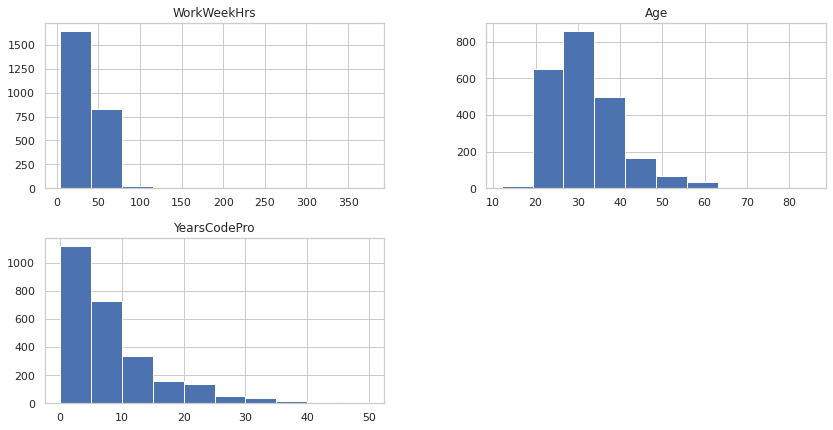

In [80]:
numeric_df.hist(figsize=(14,7));

In [83]:
outliers = (numeric_df['WorkWeekHrs'] > 50)
outliers.sum()

199

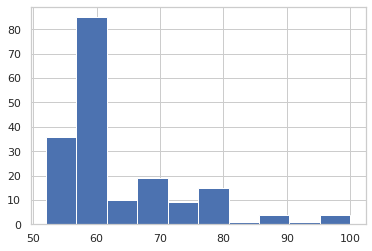

In [103]:
numeric_df.loc[outliers, 'WorkWeekHrs'].hist(bins=10);

In [89]:
maximum_possible_hours = 7 * 24
maximum_possible_hours

168

In [91]:
hour_threshold = 7 * 16
unreliable_data = numeric_df['WorkWeekHrs'] >= hour_threshold
numeric_df.loc[unreliable_data, 'WorkWeekHrs'] = np.NAN

In [96]:
(numeric_df.isna().mean().
 mul(100).round(2).sort_values().
 to_frame('Missing data (%)'))

,Missing data (%)
YearsCodePro,0.38
WorkWeekHrs,4.24
Age,12.33


In [108]:
# filling missing values with their variables means
numeric_df.fillna(numeric_df.mean(), inplace=True)

## Joining data

In [127]:
X = numeric_df.join(dummies_df).reindex(y.index)
X['intercept'] = 1
X.shape

(2601, 168)

# Features Selection

In [10]:
removed_features = []

## Correlation between numeric variables

In [11]:
numeric_data = X[numeric_cols].join(y).join(log_y)
numeric_data.head()

,WorkWeekHrs,Age,YearsCodePro,ConvertedComp,LogConvertedComp
Respondent,,,,,
36,40.0,34.0,3.0,6463.000000,8.773849
47,40.0,53.0,28.0,6247.500000,8.739937
69,40.0,25.0,3.0,49544.916667,10.810635
125,40.0,41.0,11.0,166666.666667,12.023751
147,40.0,28.0,3.0,3151.333333,8.055581


In [12]:
numeric_data.corr()

,WorkWeekHrs,Age,YearsCodePro,ConvertedComp,LogConvertedComp
WorkWeekHrs,1.000000,0.047594,0.086083,0.089570,0.116434
Age,0.047594,1.000000,0.738554,0.082314,0.285452
YearsCodePro,0.086083,0.738554,1.000000,0.122092,0.295549
ConvertedComp,0.089570,0.082314,0.122092,1.000000,0.637898
LogConvertedComp,0.116434,0.285452,0.295549,0.637898,1.000000


In [13]:
removed_features.append('Age')

## Correlation between binary variables and the intercept by questions

In [14]:
def jaccard_index(x, y):
    x_y = ((x == 1) & (y == 1)).sum()
    return x_y / (x.sum() + y.sum() - x_y)

In [15]:
correlation_threshold = 0.7

In [16]:
binary_cols = categorical_cols + ['intercept']
binary_data = X.loc[:,X.columns.str.contains('|'.join(binary_cols))]
binary_cols_corr = binary_data.corr(jaccard_index)

correlated_cols = (binary_cols_corr > correlation_threshold).sum() > 1 
binary_cols_corr.loc[correlated_cols, correlated_cols]

,LanguageWorkedWith_Python,MainBranch_I am a developer by profession,Hobbyist_Yes,Employment_Employed full-time,Gender_Man,intercept
LanguageWorkedWith_Python,1.000000,0.677083,0.698800,0.735573,0.741568,0.822760
MainBranch_I am a developer by profession,0.677083,1.000000,0.686155,0.695069,0.680160,0.786621
Hobbyist_Yes,0.698800,0.686155,1.000000,0.721849,0.711469,0.810073
Employment_Employed full-time,0.735573,0.695069,0.721849,1.000000,0.735201,0.865436
Gender_Man,0.741568,0.680160,0.711469,0.735201,1.000000,0.825067
intercept,0.822760,0.786621,0.810073,0.865436,0.825067,1.000000


In [17]:
intercept_correlated_binaries = binary_cols_corr.columns[correlated_cols].drop('intercept').tolist()
removed_features += intercept_correlated_binaries
removed_features

['Age',
 'LanguageWorkedWith_Python',
 'MainBranch_I am a developer by profession',
 'Hobbyist_Yes',
 'Employment_Employed full-time',
 'Gender_Man']

In [18]:
def select_most_efficient(data, y):
    result = []
    
    for col in data.columns:
        selected_data = data.copy()
        selected_data.drop(columns=[col], inplace=True)
        combination = selected_data.sum(axis=1)
        jaccard = jaccard_index(combination, y)
        result.append(jaccard)
    
    min_jaccard = min(result)
    min_id = result.index(min_jaccard)
    
    return data.columns[min_id], min_jaccard

In [19]:
def remove_by_linear_combination(feature_matrix, categoricals, removed_cols, threshold):
    data = feature_matrix.copy()    
    data.drop(columns=removed_cols, inplace=True)
    
    drop_cols = []
    
    for col in categoricals:
        selected_binary_cols = X.columns.str.startswith(col)
        selected_binary_data = X.loc[:,selected_binary_cols].copy()
        
        binary_combination = selected_binary_data.sum(axis=1)
        jaccard = jaccard_index(binary_combination, X['intercept'])
        
        while jaccard > threshold:
            col_to_remove, jaccard = select_most_efficient(selected_binary_data, X['intercept'])
            drop_cols.append(col_to_remove)
            selected_binary_data.drop(columns=[col_to_remove], inplace=True)
    
    return drop_cols

In [20]:
intercept_correlated_combined = remove_by_linear_combination(X, categorical_cols,
                                                             removed_features, correlation_threshold)

removed_features += intercept_correlated_combined
removed_features

['Age',
 'LanguageWorkedWith_Python',
 'MainBranch_I am a developer by profession',
 'Hobbyist_Yes',
 'Employment_Employed full-time',
 'Gender_Man',
 'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
 'JobSat_Very satisfied',
 'MainBranch_I am a developer by profession',
 'Hobbyist_Yes',
 'OrgSize_20 to 99 employees',
 'OrgSize_10,000 or more employees',
 'NEWOvertime_Often: 1-2 days per week or more',
 'Employment_Employed full-time',
 'NEWLearn_Every few months',
 'Gender_Man',
 'UndergradMajor_Computer science, computer engineering, or software engineering',
 'JobSeek_I’m not actively looking, but I am open to new opportunities']

## Correlation between binary variables

In [21]:
def biserial_corr(y, cat):
    """Compute the point-biserial correlation coefficent as specified in the wikipedia article:
    https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
    
    We are using the sample correction.
    """
    
    n = y.shape[0]
    mu = np.mean(y)
    sum_sqr_dev = np.sum((y-mu)**2)
    sigma_sample = np.sqrt(sum_sqr_dev/(n-1))
    
    g0_select = cat == 0
    n0 = g0_select.sum()
    mu0 = y[g0_select].mean()
    
    g1_select = cat == 1  
    n1 = g1_select.sum()
    mu1 = y[g1_select].mean()
    
    return   ((mu1 - mu0)/sigma_sample) * np.sqrt(n1 * n0 / (n * (n-1)))

In [22]:
cat_cols = X.columns[X.dtypes == 'uint8']

corr_list = [biserial_corr(y, X[col]) for col in cat_cols]
corr_data = pd.DataFrame(data=corr_list, index=cat_cols, columns=['corr'])
corr_data['abs_corr'] = corr_data['corr'].apply(abs)

log_corr_list = [biserial_corr(log_y, X[col]) for col in cat_cols]
log_corr_data = pd.DataFrame(data=log_corr_list, index=cat_cols, columns=['corr'])
log_corr_data['abs_corr'] = log_corr_data['corr'].apply(abs)

corr_data = corr_data.join(log_corr_data, rsuffix='_log')
corr_data

,corr,abs_corr,corr_log,abs_corr_log
"EdLevel_Associate degree (A.A., A.S., etc.)",-0.011394,0.011394,0.021412,0.021412
"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)",-0.009940,0.009940,-0.157126,0.157126
EdLevel_I never completed any formal education,0.025983,0.025983,0.002440,0.002440
"EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",-0.032664,0.032664,0.051512,0.051512
"EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)",0.027203,0.027203,0.165745,0.165745
...,...,...,...,...
DevType_Marketing or sales professional,0.122270,0.122270,0.052389,0.052389
DevType_Product manager,0.067759,0.067759,0.044671,0.044671
DevType_Scientist,0.007105,0.007105,0.049083,0.049083
DevType_Senior executive/VP,0.118481,0.118481,0.114217,0.114217


In [23]:
corr_data[['abs_corr', 'abs_corr_log']].mean()

abs_corr        0.031670
abs_corr_log    0.050953
dtype: float64

In [24]:
corr_data[['abs_corr', 'abs_corr_log']].describe().round(4)

,abs_corr,abs_corr_log
count,164.0000,164.0000
mean,0.0317,0.0510
std,0.0257,0.0407
min,0.0002,0.0008
25%,0.0120,0.0206
50%,0.0259,0.0425
75%,0.0438,0.0724
max,0.1223,0.1817


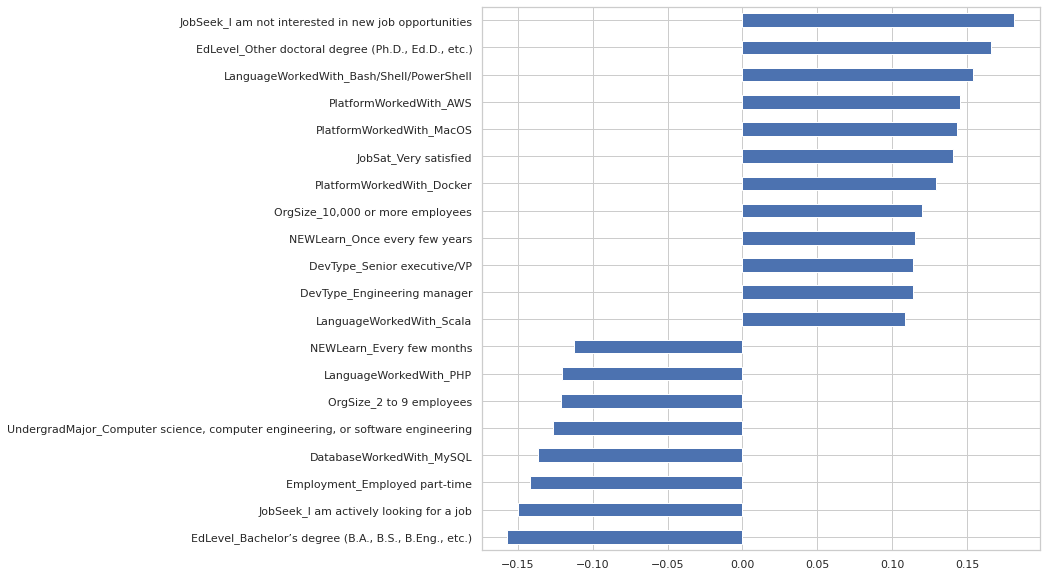

In [25]:
plot_data = corr_data.sort_values(by='abs_corr_log').tail(20)['corr_log'].sort_values()
plot_data.plot(kind='barh',figsize=(10,10));

## Technical Features Correlations

In [26]:
interesting_features = ['DatabaseWorkedWith', 'LanguageWorkedWith', 'MiscTechWorkedWith', 'PlatformWorkedWith']
selected_dummies_cols = X.columns[X.columns.str.contains('|'.join(interesting_features))]
len(selected_dummies_cols)

74

In [27]:
tech_corr_list = [biserial_corr(log_y, X[col]) for col in selected_dummies_cols]
tech_corr_data = pd.DataFrame(data=tech_corr_list, index=selected_dummies_cols, columns=['corr'])
tech_corr_data['abs_corr'] = tech_corr_data['corr'].apply(abs)
tech_corr_data.head()

,corr,abs_corr
LanguageWorkedWith_Assembly,0.017639,0.017639
LanguageWorkedWith_Bash/Shell/PowerShell,0.154308,0.154308
LanguageWorkedWith_C,-0.038743,0.038743
LanguageWorkedWith_C#,-0.042485,0.042485
LanguageWorkedWith_C++,-0.023967,0.023967


In [28]:
tech_corr_data['abs_corr'].describe()

count    74.000000
mean      0.052398
std       0.038046
min       0.000796
25%       0.024075
50%       0.044211
75%       0.078155
max       0.154308
Name: abs_corr, dtype: float64

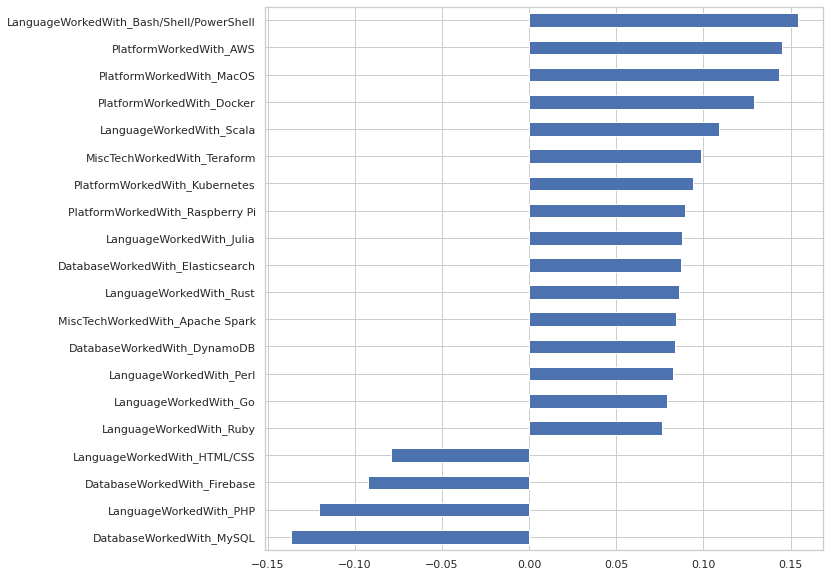

In [29]:
plot_data = tech_corr_data.sort_values(by='abs_corr').tail(20)['corr'].sort_values()
plot_data.plot(kind='barh',figsize=(10,10));

## Multicolinearity

In [30]:
def identify_multicolinearity(X, threshold=10):
    """For column in X computes its variance inflation factor and return only.
    those factors from variables that might be causing severe multicolinearity.
    As a rule of thumb a factor above 10 (default threshold) is problematic.
    
    The variance inflation factor is used to quantify the severity of multicolinearity
    in and ols regression analysis. More specificaly, it measures how much the
    variance of coefficient estimates is increased becase of collinearity
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    """
    
    data = [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
    vif = pd.Series(data=data, index=X.columns, name='vif_factor')
    critical_vif = vif[vif > threshold]
    critical_vif.drop('intercept', inplace=True)
    return critical_vif.index

In [31]:
removed_cols = removed_features

valid_cols = X.columns.drop(removed_cols)
#valid_cols = valid_cols.drop('Age')
#valid_cols = valid_cols.drop('Gender_Man')
multicolinears_cols = identify_multicolinearity(X[valid_cols])
while len(multicolinears_cols) > 0:
    less_relevant_multicol_col = corr_data.loc[multicolinears_cols, 'abs_corr_log'].idxmin()
    valid_cols = valid_cols.drop(less_relevant_multicol_col)
    removed_cols.append(less_relevant_multicol_col)
    
    multicolinears_cols = identify_multicolinearity(X[valid_cols])

print(f'Foram removidas as seguintes colunas:\n{", ".join(removed_cols)}')

Foram removidas as seguintes colunas:
Age, LanguageWorkedWith_Python, MainBranch_I am a developer by profession, Hobbyist_Yes, Employment_Employed full-time, Gender_Man, EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.), JobSat_Very satisfied, MainBranch_I am a developer by profession, Hobbyist_Yes, OrgSize_20 to 99 employees, OrgSize_10,000 or more employees, NEWOvertime_Often: 1-2 days per week or more, Employment_Employed full-time, NEWLearn_Every few months, Gender_Man, UndergradMajor_Computer science, computer engineering, or software engineering, JobSeek_I’m not actively looking, but I am open to new opportunities


In [32]:
data = [variance_inflation_factor(X[valid_cols].values, i)
        for i in range(X[valid_cols].shape[1])]
vif = pd.Series(data=data, index=valid_cols, name='vif_factor')
vif.sort_values(ascending=False)

intercept                                                                                        44.420318
MiscTechWorkedWith_.NET                                                                           2.829762
LanguageWorkedWith_C#                                                                             2.670055
MiscTechWorkedWith_Flutter                                                                        2.533274
MiscTechWorkedWith_.NET Core                                                                      2.478948
                                                                                                   ...    
NEWLearn_Once a decade                                                                            1.096447
EdLevel_Professional degree (JD, MD, etc.)                                                        1.095241
UndergradMajor_Fine arts or performing arts (such as graphic design, music, studio art, etc.)     1.083477
Gender_Non-binary, genderqueer, or ge

## Selecting significant elements

In [33]:
def get_highest_pvalue(pvalues):
    """Exluding the intercept ,return the independent variable
    with the highest pvalue in a ols regression model
    """
    
    valid_pvals = pvalues.drop(index='intercept')
    return valid_pvals.idxmax()

In [34]:
def all_significant(pvalues, alpha=0.05):
    """Excluding the intercept verify if the coefficient of
    all independent variables are statistical significant at
    a alpha level.
    """
    
    valid_pvals = pvalues.drop(index='intercept')
    condition = (valid_pvals < alpha).all()
    
    return condition

In [35]:
# This should be changed to select significant features.
# instead of a model it would return only the p-values variables

def model_lm(y, X):
    """Apply the model with feature selection
    This 
    """
    
    lm = sm.OLS(y, X)
    result = lm.fit()
    while not all_significant(result.pvalues):
        var_remove = get_highest_pvalue(result.pvalues)
        X.drop(columns=[var_remove], inplace=True)
        lm = sm.OLS(y, X)
        result = lm.fit()
    return result

In [36]:
result = model_lm(log_y, X[valid_cols].copy())
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       LogConvertedComp   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     25.11
Date:                Mon, 26 Apr 2021   Prob (F-statistic):          2.20e-174
Time:                        23:09:13   Log-Likelihood:                -3890.4
No. Observations:                2601   AIC:                             7877.
Df Residuals:                    2553   BIC:                             8158.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
WorkWeekHrs                                                                                     0.0044      0.001      3.265      0.001       0.002       0.007
YearsCodePro                                                                                    0.0371      0.003     11.983      0.000       0.031       0.043
EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                           -0.2547      0.050     -5.049      0.000      -0.354      -0.156
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)                                              0.2323      0.069      3.364      0.001       0.097       0.368
EdLevel_Some college/university study without earning a degree                                 -0.2036      0.099     -2.048      0.041      -0.398      -0.009
JobSat_Neither satisfied nor dissatisfied                                                      -0.1486      0.075     -1.975      0.048      -0.296      -0.001
JobSat_Slightly dissatisfied                                                                   -0.1773      0.064     -2.793      0.005      -0.302      -0.053
LanguageWorkedWith_Bash/Shell/PowerShell                                                        0.2149      0.046      4.641      0.000       0.124       0.306
LanguageWorkedWith_Java                                                                        -0.1138      0.050     -2.271      0.023      -0.212      -0.016
LanguageWorkedWith_Julia                                                                        0.3333      0.110      3.021      0.003       0.117       0.550
LanguageWorkedWith_Objective-C                                                                  0.3778      0.131      2.887      0.004       0.121       0.634
LanguageWorkedWith_PHP                                                                         -0.2185      0.067     -3.285      0.001      -0.349      -0.088
LanguageWorkedWith_Scala                                                                        0.2473      0.079      3.124      0.002       0.092       0.403
PlatformWorkedWith_AWS                                                                          0.2290      0.050      4.578      0.000       0.131       0.327
PlatformWorkedWith_Arduino                                                                     -0.3518      0.080     -4.408      0.000      -0.508      -0.195
PlatformWorkedWith_Docker                                                                       0.1187      0.048      2.459      0.014       0.024       0.213
PlatformWorkedWith_Heroku                  

# Adding countries variables

In [37]:
countries_dummies = pd.get_dummies(ds_df['Country'], prefix='Country')
top_countries_stds = countries_dummies.std().sort_values(ascending=False).head(10)
top_countries_stds

Country_United States     0.427962
Country_India             0.284196
Country_Germany           0.256906
Country_United Kingdom    0.246415
Country_Canada            0.184138
Country_France            0.181219
Country_Brazil            0.180233
Country_Spain             0.161317
Country_Australia         0.154430
Country_Netherlands       0.154430
dtype: float64

In [38]:
countries_cols = top_countries_stds.index
X_with_countries = X.join(countries_dummies[countries_cols])
for col in countries_cols:
    X_with_countries[col].fillna(0, inplace=True)

In [39]:
valid_countries_cols = valid_cols.tolist() + countries_cols.tolist()
result = model_lm(log_y, X_with_countries[valid_countries_cols].copy())
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       LogConvertedComp   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     54.95
Date:                Mon, 26 Apr 2021   Prob (F-statistic):          1.21e-309
Time:                        23:09:19   Log-Likelihood:                -3578.5
No. Observations:                2601   AIC:                             7239.
Df Residuals:                    2560   BIC:                             7479.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================
                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
WorkWeekHrs                                                                              0.0044      0.001      3.645      0.000       0.002       0.007
YearsCodePro                                                                             0.0272      0.003     10.047      0.000       0.022       0.032
EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                    -0.2589      0.045     -5.726      0.000      -0.348      -0.170
EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)                                       0.1905      0.059      3.206      0.001       0.074       0.307
EdLevel_Some college/university study without earning a degree                          -0.2285      0.087     -2.612      0.009      -0.400      -0.057
LanguageWorkedWith_Java                                                                 -0.0991      0.044     -2.227      0.026      -0.186      -0.012
LanguageWorkedWith_Julia                                                                 0.2234      0.097      2.295      0.022       0.032       0.414
LanguageWorkedWith_Objective-C                                                           0.4169      0.115      3.617      0.000       0.191       0.643
LanguageWorkedWith_PHP                                                                  -0.1759      0.058     -3.007      0.003      -0.291      -0.061
LanguageWorkedWith_Scala                                                                 0.3247      0.070      4.645      0.000       0.188       0.462
PlatformWorkedWith_AWS                                                                   0.1249      0.045      2.787      0.005       0.037       0.213
PlatformWorkedWith_Arduino                                                              -0.3100      0.071     -4.387      0.000      -0.449      -0.171
PlatformWorkedWith_Docker                                                                0.1467      0.042      3.500      0.000       0.065       0.229
PlatformWorkedWith_Google Cloud Platform                                                 0.1260      0.048      2.626      0.009       0.032       0.220
PlatformWorkedWith_Raspberry Pi                                                          0.1552      0.056      2.773      0.006       0.045       0.265
DatabaseWorkedWith_MySQL                                                                -0.0938      0.043     -2.168      0.030      -0.179      -0.009
DatabaseWorkedWith_Oracle                                                                0.1330      0.056      2.362      0.018       0.023       0.243
OrgSize_10 to 19 employ

# Variable descriptions

In [2]:
schema = pd.read_csv(r'data/2020_schema.csv', index_col='Column', squeeze=True)

In [40]:
selected_cols = ['CompTotal', 'CurrencyDesc', 'CurrencySymbol',
                 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
                 'NEWPurpleLink', 'SOAccount', 'SOComm', 'SOPartFreq',
                 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'NEWJobHunt',
                 'NEWJobHuntResearch', 'NEWSOSites', 'NEWStuck']

for col in excluded_cols:
    print(f'{col}: {schema[col]}\n')

NameError: name 'excluded_cols' is not defined